In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from advopt import tasks

from advopt.classifier import *
from advopt.target.utils import combine
from advopt.target import logloss, adjusted, jensen_shannon, diff_criterion
from advopt.plot.trajectories import plot_convergence, distance_to, cum_min

/mnt/mborisyak/opt/pyenv/versions/3.6.6/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
task = tasks.SwissRoll()
size = 32 * 1024

In [3]:
from sklearn.ensemble import GradientBoostingClassifier

n_trees = 500

depth = 3

clf = GradientBoostingClassifier(n_estimators=n_trees, max_depth=depth)

In [4]:
metric = jensen_shannon(clf, eps=1e-6)

In [5]:
### to obtain smooth curves we reuse the same data
### the same effect can be achieved by averaging curves over multiple runs.

data_pos = task.ground_truth_generator()(size)
data_pos_test = task.ground_truth_generator()(size)

if task.is_synthetic():
    data_neg_0 = task.ground_truth_generator()(size)
    data_neg_test_0 = task.ground_truth_generator()(size)
else:
    data_neg_0 = None
    data_neg_test_0 = None

In [6]:
from skopt import Optimizer
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import RBF, Matern

In [7]:
bo = Optimizer(
    dimensions=task.search_space(),
    base_estimator=GaussianProcessRegressor(
        kernel=Matern(length_scale=1, length_scale_bounds=(1e-2, 1e+2)),
        alpha=1e-4
    ),
    n_initial_points=5
)

In [8]:
def plot_bo(bo, xs, fs):
    xs = np.array(xs)
    fs = np.array(fs)
    
    (a, b), = task.search_space()
    
    xs_lin = np.linspace(a, b, num=100)
    m_lin = np.linspace(0, 1, num=100)
    
    plt.figure(figsize=(6, 4))
    plt.scatter(xs[:, 0], fs)
    
    mean, std = bo.models[-1].predict(m_lin.reshape(-1, 1), return_std=True)
    
    plt.plot(xs_lin, mean, color=plt.cm.tab10(0))
    plt.fill_between(xs_lin, mean - std, mean + std, color=plt.cm.tab10(0), alpha=0.2)
    plt.show()

In [9]:
observed_points = []
observed_values = []

for _ in tqdm(range(100)):
    suggestion = bo.ask()
    
    if data_neg_0 is not None:
        data_neg = task.transform(data_neg_0, suggestion)
        data_neg_test = task.transform(data_neg_test_0, suggestion)
    else:
        data_neg = task.generator(suggestion)(size)
        data_neg_test = task.generator(suggestion)(size)
    
    jsd_train, jsd_test = metric(data_pos, data_neg, data_pos_test, data_neg_test)
    
    jsd = (np.mean(jsd_train) + np.mean(jsd_test)) / 2
    
    observed_points.append(suggestion)
    observed_values.append(jsd)
    
    bo.tell(suggestion, jsd)

/mnt/mborisyak/opt/pyenv/versions/3.6.6/envs/py3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/mnt/mborisyak/opt/pyenv/versions/3.6.6/envs/py3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [10]:
solution = [0, ] * task.ndim() + [1, ] * task.ndim()

min_dist = cum_min(distance_to(solution), observed_points, observed_values)

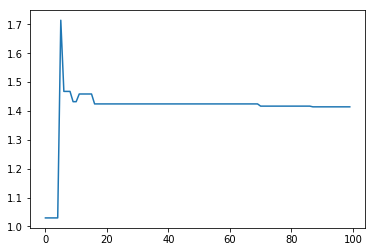

In [11]:
plt.plot(min_dist)